# Quantum Neuron

In this work, we build [quantum neuron](https://arxiv.org/abs/1711.11240) with [PennyLane](https://pennylane.ai/), and run it on different devices such as SV1, IonQ, and Aspen-M-2.
We aim to reproduce Fig.1(d) of the paper.

In [1]:
from qn.quantum_neuron import (
    generate_random_numbers,
    linear_combination,
    quantum_neuron,
    activation_function
)

'''
from braket.experimental.algorithms.quantum_neuron import (
    generate_random_numbers,
    linear_combination,
    quantum_neuron,
    activation_function
)
'''

'\nfrom braket.experimental.algorithms.quantum_neuron import (\n    generate_random_numbers,\n    linear_combination,\n    quantum_neuron,\n    activation_function\n)\n'

In [2]:
import time, os, sys, ast
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from braket.aws import AwsQuantumJob
from braket.jobs.image_uris import Framework, retrieve_image

import pennylane as qml

In [3]:
print(qml.version())

0.27.0


## Introduction
Machine learning is used in many areas of everyday life. The technology has developed so far largely due to advances in neural networks. It can be seen that a neural network is composed of many neurons connected together. In other words, a neuron is the basic unit of a neural network. Since many studies had been done on neurons and show successful results, several approaches to combine it with quantum computing are also proposed. Such approaches are called quantum neuron. The advantage of the method is that you can process classical neural network tasks maintaining the ability to have superpositions of inputs and proserve quantum coherence and entanglement.

The below shows classical and quantum neuron, based on Figure 1 of the paper. At the end of this work, you can get to learn how to build a non-linear transformation from linear nature of quantum mechanics.
<div align="center"><img src="img/classical_and_quantum_neuron.png"/></div>

## Building Linear Combination Circuit

Before we explain a quantum neuron, let us review a classical neuron. A classical neuron is a function that takes $n$ variables $x_1, \cdots, x_n$ and maps them to the output value $a=\sigma\left(w_1 x_1+w_2 x_2+\cdots+w_n x_n+b\right)$ with $\{w_i\}$ and $b$ being the synaptic weights and bias, respectively (shown in (a)). The quantity $\theta = w_1 x_1+w_2 x_2+\cdots+w_n x_n+b$ is called the input signal to the neuron. The activation function $\sigma(z)$ is a nonlinear function such as the step function and the sigmoid function.

In order to mimic the classical neuron, first, we use inputs $\left| x \right> = \left| x_1 ... x_n  \right>$ as a control state and apply $R_y(2w_i)$ onto an ancilla qubit conditioned on the $i$-th qubit, followed by $R_y(2b)$ on the ancilla qubit. This ammounts to applying the $R_y(2\theta)$ on the ancilla qubit conditioned on the input state $\left| x \right>$ (shown in (b) and below). (At the bottom of the below figure, we simplify these circuits). This process means the linear combination of the inputs $\{x_i\}$, the weights $\{w_i\}$, and bias $b$.

<div align="center"><img src="img/linear_combination_circuit.png"/></div>

We can calculate the effect of the circuit:
$$
\begin{split}
    &\left| x_1 ... x_n  \right> \otimes \left| 0 \right> \\
    &\xrightarrow{1} \left| x_1 ... x_n \right> \otimes Ry(2w_1 x_1) \left| 0 \right> \\
    &\xrightarrow{2} \left| x_1 ... x_n \right> \otimes Ry(2w_1 x_1 + 2w_n x_n) \left| 0 \right> \\
    &\xrightarrow{3} \left| x_1 ... x_n \right> \otimes Ry(2w_1 x_1 + 2w_n x_n + 2b) \left| 0 \right> \\
    &= \left| x_1 ... x_n \right> \otimes Ry(2\theta) \left| 0 \right> \\
\end{split}
$$
where the two terms separated by tensor product represent, from left to right, inputs, and ancilla qubit(s), respectively.

## Build Activation Function Circuit

Secondly, after building a linear combination circuit, we build an activation function circuit. However it seems a unique idea that came out of nowhere, we show how to build an activation function circuit below.

<div align="center"><img src="img/activation_function_circuit.png"/></div>

In this circuit, we prepare inputs $\left| x \right>$, ancilla $\left| 0 \right>$, and output $\left| \psi \right>$ as initial state.
We post the detailed calculation in Appx, but as a result, one measure the ancilla qubit of the circuit (④), and if it is 0, the output qubit is $R_y(2q(\theta))\left| \psi \right>$ (where $ q(\theta) = \arctan(\tan^2 \theta)$). This means that a non-linear function is operated on the output qubit! What happens when 1 is measured? In such a case, the output qubit become $R_y(-\frac{\pi}{2})\left| \psi \right>$, so we can operate $R_y(\frac{\pi}{2})$ to correct it to $\left| 0 \right>$.

The shape of $q(\theta) = \arctan(\tan^2 \theta)$ is similar to [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), which have been used as activation function of classical neurons (as shown below).

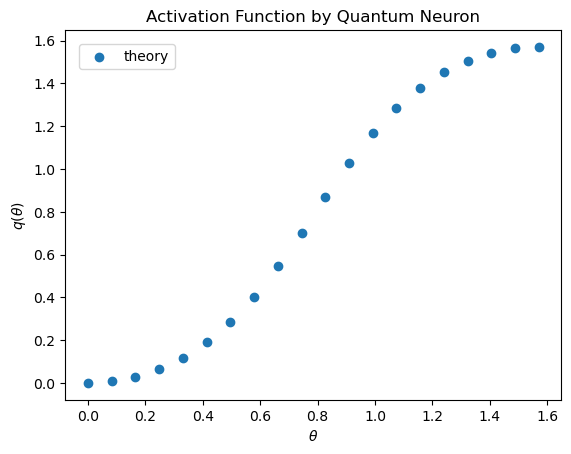

In [4]:
x_array = np.linspace(0, np.pi/2, 20)
nl_function = np.arctan(np.tan(x_array)**2)

plt.scatter(x_array, nl_function, label=r"theory")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$q(\theta)$")
plt.title('Activation Function by Quantum Neuron')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1)
plt.show()

# References 
[1] Yudong Cao, Gian Giacomo Guerreschi, Alán Aspuru-Guzik, "Quantum Neuron: an elementary building block for machine learning on quantum computers", (2017), [arXiv:1711.11240](https://arxiv.org/abs/1711.11240)

# [Optional] Print the circuits

In [5]:
n_inputs = 4

In [6]:
bias = 0.05    # constant
weights = generate_random_numbers(n_inputs, np.pi/2-bias)
print(weights)
inputs_list = [format(i, f'0{n_inputs}b') for i in range(2**n_inputs)]

[0.03464765739182245, 0.15436116079311354, 0.39528521365787317, 0.6472795562698698]


In [7]:
theta = np.inner(np.array(list(inputs_list[11]), dtype=int), np.array(weights)) + bias   # linear comination with numpy
theta = theta.item()   # Convert numpy array to native python float-type

ancilla = n_inputs # ID of an ancilla qubit
output = n_inputs + 1  # ID of an output qubit
n_qubits = n_inputs + 2  # +2: ancilla and output

### Print Linear Combination Circuits

In [8]:
n_lc_qubits = n_inputs + 1
lc_dev = qml.device(
    "braket.local.qubit",
    wires=n_lc_qubits,
    shots=100)

@qml.qnode(lc_dev)
def lc_circuit():
    # test for inputs_list[11] (='1011')
    linear_combination(inputs_list[11], weights, bias, ancilla, n_qubits)
    
    return qml.expval(qml.PauliZ(ancilla))

/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarni

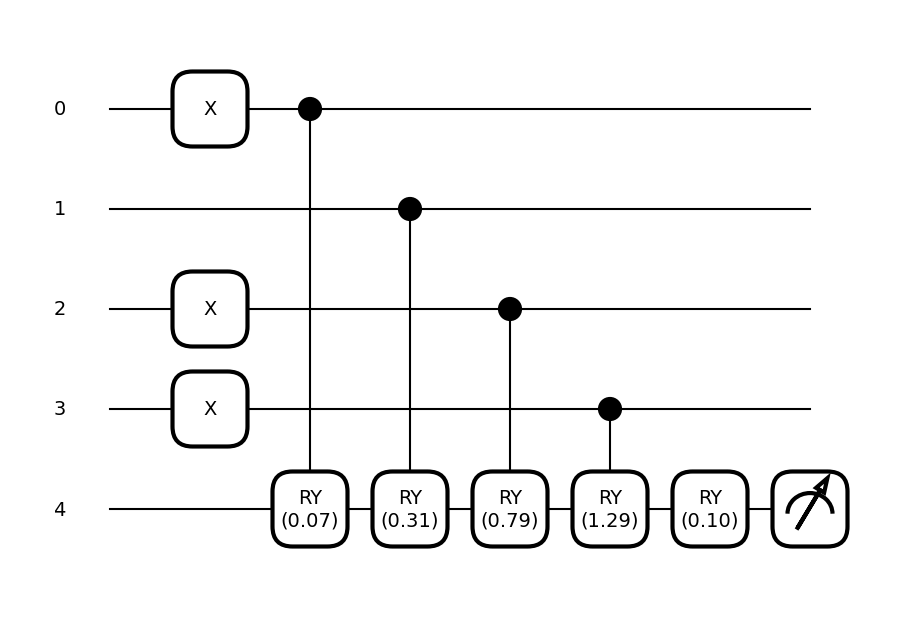

In [9]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(lc_circuit, decimals=2)()
plt.show()

### Print Activation Function Circuits

/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The datapath rcparam was deprecated in Matplotlib 3.2.1 and will be removed two minor releases later.
  self[key] = other[key]
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/home/ec2-user/anaconda3/envs/Braket/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarni

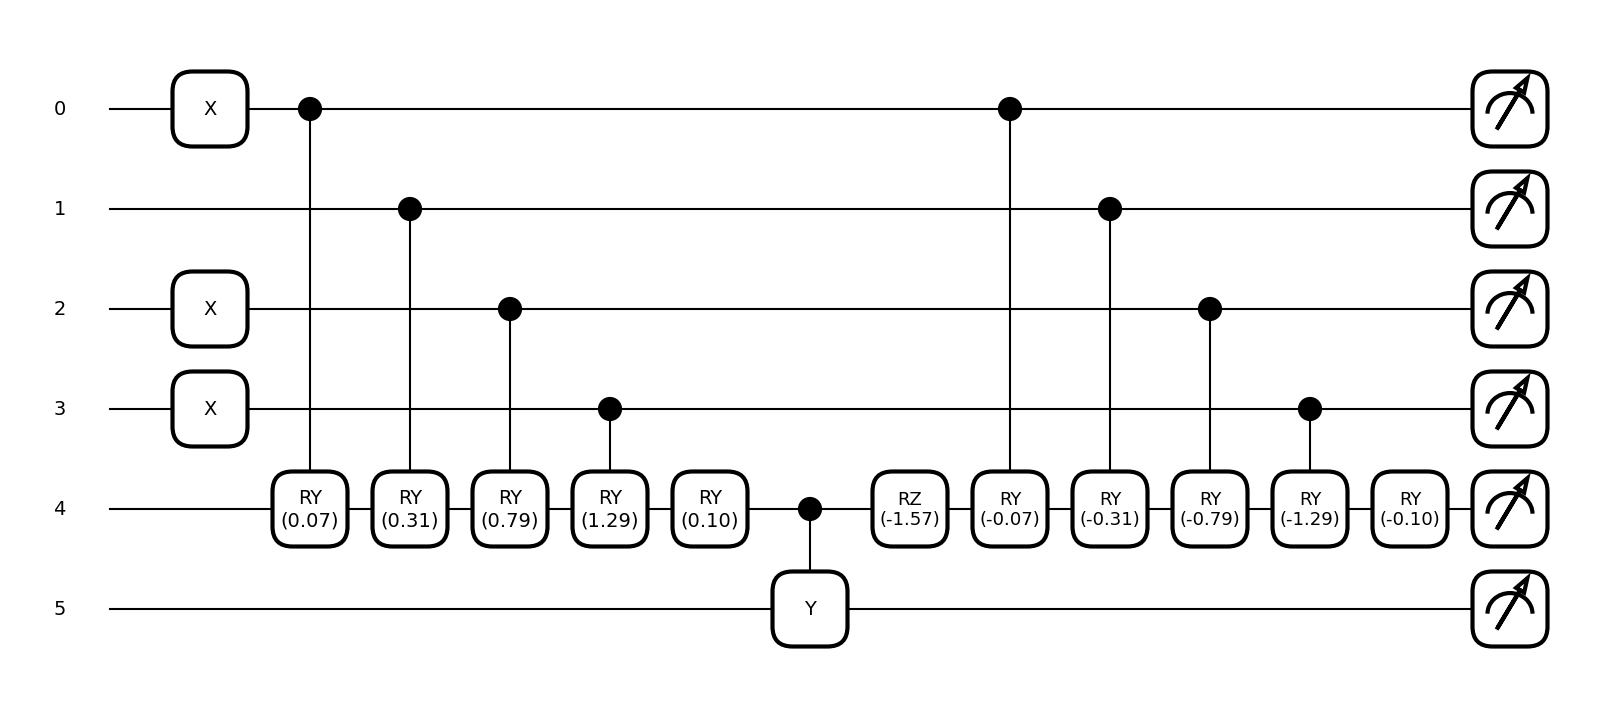

In [10]:
af_dev = qml.device(
    "braket.local.qubit",
    wires=n_qubits,
    shots=100)

@qml.qnode(af_dev)
def af_circuit():
    # test for inputs_list[11] (='1011')
    activation_function(inputs_list[11], weights, bias, ancilla, output, n_qubits)
    
    return [qml.sample(qml.PauliZ(i)) for i in range(n_qubits)]
    
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(af_circuit, decimals=2)()
plt.show()

### post-processing

When building the activation function circuit using PennyLane, we don't actually correct the output qubit in  "1" cases. We only adopt the "0" cases.

In [11]:
sample = af_circuit()
sample = sample.T
sample = (1 - sample.numpy()) / 2

print('In the sample obtained, we adopt the cases where its ancilla qubit is 0.')
adopted_sample = sample[sample[:,ancilla] == 0]

print(adopted_sample)

In the sample obtained, we adopt the cases where its ancilla qubit is 0.
[[1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 0.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1. 0. 1. 1. 0. 1.]
 [1

The last qubit of `adopted_sample` represents a measurement result of $Ry(2q(\theta)) \left|0\right>$.

Let $p_0$ be the probability of 0 when measuring output qubit.
Using $ Ry(2q(\theta)) \left|0\right> = \cos q(\theta) \left|0\right> + \sin q(\theta) \left|1\right>$,
$$ p_0 = \cos^2 q(\theta) \\
\therefore q(\theta) = \cos^{-1}\sqrt{p_0}$$

In [12]:
count_0 = len(adopted_sample[adopted_sample[:,output] == 0])
count_1 = len(adopted_sample[adopted_sample[:,output] == 1])

p_0 = count_0 / (count_0 + count_1)
q_theta = np.arccos(np.sqrt(p_0))
print(f'theta: {theta}')
print(f'q_theta: {q_theta}')

theta: 1.1272124273195654
q_theta: 1.2820534188408945


## Run on AWS managed Simulator and QPU
Now, let's repeat the quantum neuron circuit on quntum devices such as SV1 and IonQ, changing $\theta$ slightly.

In [13]:
# Hybrid Jobs general setting

# Using autograd interface with Base container
interface = "autograd"
hyperparameters = {
        "n_inputs": n_inputs,
        "shots": "100",
        "interface": interface,
        # Maximum number of simultaneous tasks allowed
        "max_parallel": "10",
}

### Run on AWS Simulator (SV1)

In [14]:
# Hybrid Jobs setting specific for SV1

region = 'us-east-1'
image_uri = retrieve_image(Framework.BASE, region)
sv1 = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

In [15]:
# Run on SV1

sv1_job = AwsQuantumJob.create(
    device=sv1,
    source_module="qn",
    job_name="qn-job-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    # Relative to the source_module
    entry_point="qn.quantum_neuron",
    copy_checkpoints_from_job=None,
    # general parameters
    hyperparameters=hyperparameters,
    wait_until_complete=False
)

In [16]:
print(sv1_job.state())

QUEUED


In [19]:
print("SV1 Task Summary")
print(sv1_job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run the job with SV1: {sv1_job.result()['estimated cost']} USD")

SV1 Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 1600, 'tasks': {'COMPLETED': 16}, 'execution_duration': 0.933, 'billed_execution_duration': 48.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run the job with SV1: 0.06 USD


### Run on QPU (IonQ)

In [21]:
# Hybrid Jobs setting specific for IonQ

region = 'us-east-1'
image_uri = retrieve_image(Framework.BASE, region)
ionq = "arn:aws:braket:::device/qpu/ionq/ionQdevice"

In [22]:
# Run on IonQ

ionq_job = AwsQuantumJob.create(
    device=ionq,
    source_module="qn",
    job_name="qn-job-" + interface + "-" + str(int(time.time())),
    image_uri=image_uri,
    # Relative to the source_module
    entry_point="qn.quantum_neuron",
    copy_checkpoints_from_job=None,
    # general parameters
    hyperparameters=hyperparameters,
    input_data="inputs.txt",
    wait_until_complete=False
)

In [26]:
print(ionq_job.state())

COMPLETED


In [27]:
print("IonQ Task Summary")
print(ionq_job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket quantum processing unit (QPU). Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run the job with IonQ: {ionq_job.result()['estimated cost']} USD")

IonQ Task Summary
{'arn:aws:braket:::device/qpu/ionq/ionQdevice': {'shots': 1600, 'tasks': {'COMPLETED': 16}}}
Note: Charges shown are estimates based on your Amazon Braket quantum processing unit (QPU). Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run the job with IonQ: 20.8 USD


## Results

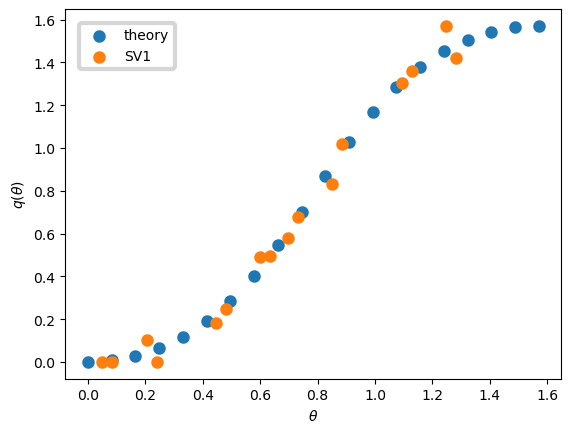

In [20]:
x_array = np.linspace(0, np.pi/2, 20)
nl_function = np.arctan(np.tan(x_array)**2)
sv1_theta_list = sv1_job.result()['theta_list']
sv1_q_theta_list = sv1_job.result()['q_theta_list']
# ionq_theta_list = ionq_job.result()['theta_list']
# ionq_q_theta_list = ionq_job.result()['q_theta_list']

plt.scatter(x_array, nl_function, label=r"theory")
plt.scatter(sv1_theta_list, sv1_q_theta_list, label=r"SV1")
# plt.plot(ionq_theta_list, ionq_q_theta_list, label=r"IonQ")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$q(\theta)$")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1)
plt.show()